# ENGRI 1120 Lab 8: Analysis of continuous stirred tank reactor with a single irreversible chemical reaction

<img src="figs/Fig-Lab-8-Reactor.png" style="width:40%">

##### __Fig. 1__. Chemical reactor schematic. A single liquid phase reaction produces the product $P$ from the precursor molecules $A$ and $B$.

### Introduction
Suppose we have a reaction set $\mathcal{R}$ involving the species set $\mathcal{M}$ that is occurring in a well-mixed chemical reactor with stream set $\mathcal{S}$. Then the concentration of component $i\in\mathcal{M}$ is given by:

$$\frac{d}{dt}\left(C_{i}V\right) = \sum_{s\in\mathcal{S}}v_{s}C_{s,i}\dot{V}_{s} + \sum_{r\in\mathcal{R}}\sigma_{ir}\hat{r}_{r}V\qquad\forall{i}\in\mathcal{M}$$

where $C_{s,i}$ denotes the concentration of component $i\in\mathcal{M}$ in stream $s\in\mathcal{S}$, $\sigma_{ir}$ denotes the stoichiometric coefficient for component $i\in\mathcal{M}$ in reaction $r\in\mathcal{R}$, $\dot{V}_{s}$ denotes the volumetric flow rate of stream $s\in\mathcal{S}$, $V$ denotes the volume of the reaction mixture in the reactor unit, $v_{s}$ denotes the direction parameter for stream $s\in\mathcal{S}$ and the quantity $C_{i}$ denotes the concentration of component $i\in\mathcal{M}$ in the reaction vessel. Finally, the terms $\hat{r}_{r}$ denote the _reaction rate per unit volume_ for reaction $r\in\mathcal{R}$ that is occurring in the reaction vessel. 

#### Constant volume, steady-state:
When the reaction is at constant volume, we can pull the volume $V$ out of the accumulation term and divide by the volume to give:

$$\frac{dC_{i}}{dt} = \sum_{s\in\mathcal{S}}v_{s}C_{s,i}D_{s} + \sum_{r\in\mathcal{R}}\sigma_{ir}\hat{r}_{r}\qquad\forall{i}\in\mathcal{M}$$

where $D_{s}$ is called the _dilution rate_ for stream $s\in\mathcal{S}$; the dilution rate has units of inverse time. Finally, at steady-state, all accumulation terms vanish, giving:

$$\sum_{s\in\mathcal{S}}v_{s}C_{s,i}D_{s} + \sum_{r\in\mathcal{R}}\sigma_{ir}\hat{r}_{r} = 0\qquad\forall{i}\in\mathcal{M}$$

#### Problem setup and assumptions
Let's do some calculations for the reactor shown in Fig. 1; an irreversible liquid phase reaction occurs, which converts $A$ and $B$ into product $P according to the reaction:

$$2A+B\longrightarrow{P}$$

at the rate $\hat{r}_{1}$ (units: mol/volume-time). The volume of the reactor $V$ = 5L. Stream 1 has a volumetric flow rate $\dot{V}_{1}$ = 200 mL/h and Stream 2 has a volumetric flow rate $\dot{V}_{2}$ = 300 mL/h. The concentration(s) of $A$ in the stream 1 is $C_{1,1}$ = 50 mmol/L, there is no $B$ and $C$ in stream $1$. The concentration(s) of $B$ in the stream 2 is $C_{2,2}$ = 75 mmol/L, there is no $A$ or $C$ in stream $2$. The rate constant for rate $1$ is given by: $k_{1}$ = 0.56 units. 

__Assumptions__:
* The reactor is well-mixed
* The rate of reaction for $\hat{r}_{1}$ follows mass action kinetics

### Lab setup
The code block below installs (and loads) [Julia](https://julialang.org) packages that we use to solve the species concentration balance equations.

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/labs/lab-8-fun-w-mass-action-kinetics`
  No Changes to `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/labs/lab-8-fun-w-mass-action-kinetics/Project.toml`
  No Changes to `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/labs/lab-8-fun-w-mass-action-kinetics/Manifest.toml`


In [2]:
# load required packages 
using DifferentialEquations
using Optim
using Plots
using Colors

# setup paths -
const _ROOT = pwd();
const _PATH_TO_FIGS = joinpath(_ROOT, "figs");

#### Load the Lab 8 code library
The call to the `include` function loads the `ENGRI-1120-Lab-6-CodeLib.jl` library into the notebook; the library contains functions we can use during the lab. In particular:

#### Functions
* The `kinetics(x::Array{Float64,1}, k::Float64) -> Float64` function computes the value of reaction rate $\hat{r}_{1}$ given the concentrations in the `x::Array{Float64,1}` array and the rate constant `k::Float64`.
* The `evaluate(model::Dict{String, Any}; tspan::Tuple{Float64, Float64} = (0.0,20.0), Δt::Float64 = 0.01) --> (T,X)` computes the numerical solution of the concentration balances; the time is stored in the `T::Array{Float64,1}` array. The concentrations are stored in the `X::Array{Float64,2}` array; each row of `X::Array{Float64,2}` corresponds to a time point, while each column holds the concentration of a species
* The `objfunc(x::Array{Float64,1}, model::Dict{String, Any}) --> Float64` function is called by `Optim` to estimate the `residual` of the concentration balances.

In [3]:
include("ENGRI-1120-Lab-8-CodeLib-Soln.jl");

In [4]:
# setup some constants from the problem -
V = 5.0; # units: L
V̇₁ = 200.0*(1/1000); # units: L/hr
V̇₂ = 300.0*(1/1000); # units: L/hr

# rate constant -
k₁ = 0.56;

# Feed concentrations -
A_in = 50.0; # units: mmol/L
B_in = 75.0; # units: mmol/L
C_in = 0.0;  # units: mmol/L (no product in any feed)

# initial condition in the reactor -
xₒ = [0.1, 0.1, 1e-6];

### Setup task: Formulate the stoichiometric array, the composition array and the dilution vector

In [5]:
# setup stoichiometric array -
S = [
    -2.0 ; # 1 A
    -1.0 ; # 2 B
     1.0 ;  # 3 C
];

# setup the dilution rate vector -
D = [
    (V̇₁/V)        ; # 1 D₁ units: 1/hr
    (V̇₂/V)        ; # 2 D₂ units: 1/hr
    ((V̇₁ + V̇₂)/V) ; # 3 D₃ units: 1/hr
];

# setup concentration array -
CM = [
    A_in 0.0 0.0 ; # species 1
    0.0 B_in 0.0 ; # species 2
    0.0 0.0 0.0  ; # species 3
];

### Setup task: Put all our data into a `model` dictionary

In [6]:
# initialize Dict data structrure -
model = Dict{String, Any}();

# constants from the problem -
model["number_of_dynamic_states"] = 3;
model["initial_condition_array"] = xₒ;

# data set by you -
model["S"] = S;
model["k"] = k₁;
model["D"] = D;
model["CM"] = CM;

### a) Estimate of the dynamic exit concentration for a constant feed
To estimate the `dynamics` in the reactor, we need to numerically solve the differential concentration balance equations, e.g., using methods such as the [Euler method](https://en.wikipedia.org/wiki/Euler_method). We'll use more sophisticated methods found in [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/). To interface with these solvers, use the `evaluate` function imported from `ENGRI-1120-Lab-8-CodeLib-Soln.jl`.

In [7]:
(T, X) = evaluate(model; tspan=(0.0, 30.0));

### b) Estimate the steady state exit composition as an optimization problem
To estimate the steady-state concentration, we need to solve an `optimization` problem, i.e., we need to `search` for exit concentrations that make our concentration balances zero. We do this via the [Optim.jl](https://julianlsolvers.github.io/Optim.jl/stable/) package. The problem we are solving is to find a concentration vector $x$ that makes the residual $\epsilon$ small:

$$\min_{x}\epsilon^{T}\epsilon$$

subject to the constraints on the concentration $0\leq{x}\leq\infty$. We'll use a derivative-free search method called [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder–Mead_method) to generate candidate values for the concentration vector $x$; we'll keep generating guesses and checking their residual values until we find a candidate solution that meets some smallness criteria.

In [8]:
# Setup the objective function (this is the function that we will minimize)
OF(x) = objfunc(x, model)

# setup bounds -
L = [0.0, 0.0, 0.0];  # lower bound is zero (concentration ≥ 0)
U = [Inf, Inf, Inf];  # upper bound is Inf (concentration ≤ ∞)
    
# call the optimizer -
opt_result = optimize(OF, L, U, xₒ, Fminbox(NelderMead()))

 * Status: success

 * Candidate solution
    Final objective value:     6.248246e-10

 * Found with
    Algorithm:     Fminbox with Nelder-Mead

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.76e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    651
    ∇f(x) calls:   1


In [9]:
nm_soln = Optim.minimizer(opt_result)

3-element Vector{Float64}:
  0.2954988377892016
 20.148022595731934
  9.852165444819672

### c) Visualize the dynamic and steady-state solutions

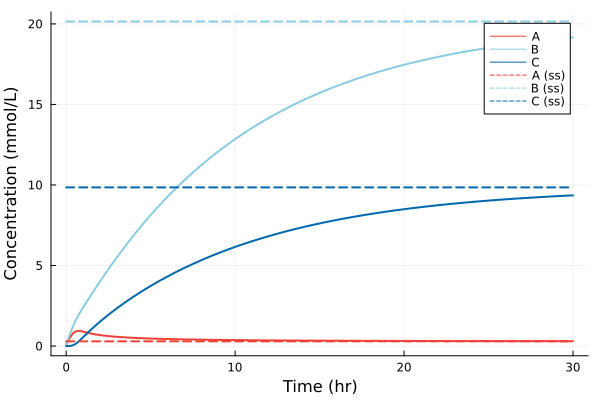

In [10]:
# grab the steady-state solutions -
x̄₁ = nm_soln[1];
x̄₂ = nm_soln[2];
x̄₃ = nm_soln[3];

# how many simulation data points do we have?
Nₛ = length(T);

# plot the simulation -
plot(T,X[:,1],lw=2,c=colorant"#EF4035", label="A")
plot!(T,X[:,2],lw=2,c=colorant"#89CCE2", label="B")
plot!(T,X[:,3],lw=2,c=colorant"#0068AC", label="C")

# plot the steady-states -
plot!(T, x̄₁*ones(Nₛ), lw=2,c=colorant"#EF4035", label="A (ss)", ls=:dash) 
plot!(T, x̄₂*ones(Nₛ), lw=2,c=colorant"#89CCE2", label="B (ss)", ls=:dash) 
plot!(T, x̄₃*ones(Nₛ), lw=2,c=colorant"#0068AC", label="C (ss)", ls=:dash) 

# labels -
xlabel!("Time (hr)", fontsize=18);
ylabel!("Concentration (mmol/L)", fontsize=18)

### d) Wow! This takes a long time to reach steady-state. How can we change this to shorten the time we have to wait?

In [11]:
# your ideas go here ... check them by running some simulations!